# Implementación 1: Modelo RandomForest

## Importación de librerias y creación de funciones

In [210]:
# Importar las bibliotecas necesarias
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV,ShuffleSplit
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_score,f1_score

In [211]:
def cargar_csv(ruta_csv):
    try:
        df = pd.read_csv(ruta_csv)
        return df
    except FileNotFoundError:
        print(f"El archivo en la ruta {ruta_csv} no se encontró.")
    except pd.errors.EmptyDataError:
        print("El archivo CSV está vacío.")
    except pd.errors.ParserError:
        print("Error al analizar el archivo CSV.")
    except Exception as e:
        print(f"Ocurrió un error: {e}")

In [229]:
def export_pickle(objeto, ruta_archivo):
    # Verificar si la ruta del directorio existe, si no, crearla
    directorio = os.path.dirname(ruta_archivo)
    if not os.path.exists(directorio):
        os.makedirs(directorio)

    # Guardar el objeto en un archivo pickle en la ruta especificada
    with open(ruta_archivo, 'wb') as archivo:
        pickle.dump(objeto, archivo)
    print(f'Objeto exportado exitosamente a {ruta_archivo}')

In [212]:
df=cargar_csv(os.path.join('..','Data','output','train_data_1.csv'))

## Desarrollo

### Parametrización

En esta sección se busca parametrizar el desarrollo, dividir el conjunto de datos, definir parámetros de entrenamiento y hacer la creación del pipeline para el modelo

In [213]:
independent_var_erase=['10d']
dependent_var='deslizamientos'
independent_var=[x for x in df.columns if x not in independent_var_erase and x not in dependent_var]

In [214]:
X=df[independent_var]
y=df[dependent_var]

# Seleccionar columnas categoricas
VAR_categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Seleccionar columnas numericas
VAR_numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Total de columnas
VAR_cols = VAR_categorical_cols + VAR_numerical_cols

print('Variables categoricas: ',VAR_categorical_cols)
print('Variables numericas: ',VAR_numerical_cols)
print('Variables independientes: ',VAR_cols)

Variables categoricas:  ['zonificacion', 'Nomenclatura_del_Suelo', 'tipo_geologia']
Variables numericas:  ['ELEVACION', 'PENDIENT', '24h', '7d', '15d', '30d', '60d', '90d']
Variables independientes:  ['zonificacion', 'Nomenclatura_del_Suelo', 'tipo_geologia', 'ELEVACION', 'PENDIENT', '24h', '7d', '15d', '30d', '60d', '90d']


Esto nos indica cuales son las variables que usaremos para el entrenamiento y cuales variables eliminamos, adicionalmente guardamos por separados las variables categóricas y las numéricas para su tratamiento

In [215]:
# Crea un diccionario para los codificadores
label_encoders = {}

for feature in VAR_categorical_cols:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])
    label_encoders[feature] = le

In [216]:
label_encoders

{'zonificacion': LabelEncoder(),
 'Nomenclatura_del_Suelo': LabelEncoder(),
 'tipo_geologia': LabelEncoder()}

Creamos los codificadores, usaremos `LabelEncoder()` debido a la cantidad de clases que puede tomar cada variable categórica, optimizando recursos computacionales. 

Este objeto nos servirá para codificar valores nuevos que entren al modelo 

In [217]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2)

In [218]:
shuffle_split = ShuffleSplit(test_size=.3, train_size=.7, n_splits=10)

Como se había explicado en la seccion de Contextualización, usaremos [validación cruzada aleatoria y dividida](intro.md#esquema-de-entrenamiento)

In [219]:
param_grid_rf = {
    'classifier__n_estimators': [100,250,500], 
    'classifier__max_depth': [3, 6, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
    }

In [220]:
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), VAR_numerical_cols)
    ],
    remainder='passthrough'
)

In [221]:
pipeline_rf= Pipeline([
    ('preprocessor',preprocessor_rf),
    ('classifier', RandomForestClassifier())
])
pipeline_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['ELEVACION', 'PENDIENT',
                                                   '24h', '7d', '15d', '30d',
                                                   '60d', '90d'])])),
                ('classifier', RandomForestClassifier())])

Esto quiere decir que nuestro pipeline encapsula un proceso en el que las columnas numéricas pasan por un proceso de estandarización antes de pasar al modelo

In [222]:
X_train.head()

,ELEVACION,PENDIENT,zonificacion,Nomenclatura_del_Suelo,tipo_geologia,24h,7d,15d,30d,60d,90d
143,1073.708740,6.012948,4,25,9,0.0,104.0,260.0,446.0,553.0,711.0
321,1087.004517,21.071693,4,25,9,0.0,104.0,260.0,446.0,553.0,711.0
629,1109.522949,13.987661,5,25,9,10.0,193.0,311.0,583.0,735.0,918.0
944,978.786621,3.903704,5,25,4,0.0,0.0,1.2,4.3,69.4,142.9
442,1043.582886,42.156261,4,25,9,0.0,182.0,244.0,566.0,735.0,878.0


In [223]:
y_train.head()

143    0
321    0
629    0
944    1
442    0
Name: deslizamientos, dtype: int64

Así se ve nuestra data de entrenamiento que pasará por el `Pipeline` que se definió

### Rendimiento en Training

La siguiente celda de código junta todas las piezas que definimos previamente, y entrena el modelo de clasificación. Después imprime un mensaje personalizado con el pipeline definido y la combinación de parámetros ganadora

In [224]:
grid_search = GridSearchCV(pipeline_rf, param_grid_rf, cv=shuffle_split,scoring='precision', return_train_score=True)
grid_search.fit(X_train, y_train)
msg_training=f"Rendimiento en training -> RandomForestClassifier \n modelo ganador: {grid_search.best_estimator_} \n mejor combinacion de parametros: {grid_search.best_params_}"
print(msg_training)
model_rf=grid_search.best_estimator_

Rendimiento en training -> RandomForestClassifier 
 modelo ganador: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['ELEVACION', 'PENDIENT',
                                                   '24h', '7d', '15d', '30d',
                                                   '60d', '90d'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=5,
                                        n_estimators=500))]) 
 mejor combinacion de parametros: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 500}


In [225]:
# Resultados del GridSearchCV
results_rf = grid_search.cv_results_
#  Convertir los resultados en un DataFrame para una mejor visualización
df_results = pd.DataFrame(grid_search.cv_results_)

# Mostrar solo las columnas relevantes
df_results = df_results[['rank_test_score','param_classifier__n_estimators','param_classifier__max_depth', 'param_classifier__min_samples_split','param_classifier__min_samples_leaf', 'mean_train_score', 'mean_test_score']]
df_results=df_results.rename(columns={'param_classifier__n_estimators':'n_estimators',
                                      'param_classifier__max_depth':'max_depth',
                                      'param_classifier__min_samples_split':'min_samples_split',
                                      'param_classifier__min_samples_leaf':'min_samples_leaf',
                                      'mean_train_score':'Rendimiento promedio - Train',
                                      'mean_test_score':'Rendimiento promedio - Test',
                                      'rank_test_score':'Model Ranking'
                                      })
# Ordenar por la mejor puntuación en test
df_sorted = df_results.sort_values(by='Model Ranking', ascending=True)

# Mostrar las primeras 10 filas (los mejores modelos)
df_sorted.head(10)

,Model Ranking,n_estimators,max_depth,min_samples_split,min_samples_leaf,Rendimiento promedio - Train,Rendimiento promedio - Test
59,1,500,10,5,1,0.998196,0.945435
57,2,100,10,5,1,0.999112,0.944721
54,3,100,10,2,1,1.000000,0.944066
28,4,250,6,2,1,0.990766,0.943483
56,5,500,10,2,1,1.000000,0.942249
61,6,250,10,10,1,0.988999,0.942138
55,7,250,10,2,1,1.000000,0.939637
58,8,250,10,5,1,0.998640,0.937331
62,9,500,10,10,1,0.988956,0.936936
31,10,250,6,5,1,0.987597,0.936404


Las métricas de rendimiento en el conjunto de entrenamiento y prueba se calculan durante el proceso de búsqueda de hiperparámetros.

En esta tabla podemos ver el top 10 de los modelos que fueron entrenados con los valores de sus parámetros. Como podemos ver, el modelo ganador, es aquel que tiene el valor de `Model Ranking` como 1. Podemos ver su puntaje en Entrenamiento y en Prueba, vemos que tuvo muy buenos puntajes

### Rendimiento en Test

In [226]:
y_pred_rf = model_rf.predict(X_valid)
precision_rf = precision_score(y_valid, y_pred_rf)
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
recall_rf = recall_score(y_valid, y_pred_rf)
f1_rf = f1_score(y_valid, y_pred_rf)

data_reporte_rf = {
    'Modelo': ['Random Forest Classifier'],
    'Precision': [precision_rf],
    'Recall': [recall_rf],
    'Exactitud': [accuracy_rf],
    'F1-score': [f1_rf]
}

df_reporte_rf = pd.DataFrame(data_reporte_rf)
df_reporte_rf

,Modelo,Precision,Recall,Exactitud,F1-score
0,Random Forest Classifier,0.949367,0.882353,0.926316,0.914634


Al probar el modelo ganador con datos de validación que nunca ha visto, miramos que las métricas se mantienen y son muy buenas

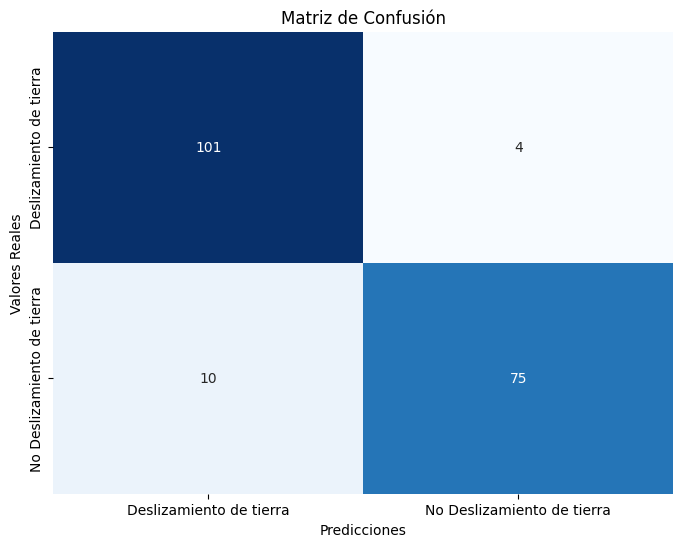

In [227]:
cm = confusion_matrix(y_valid, y_pred_rf)
# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Deslizamiento de tierra', 'No Deslizamiento de tierra'], yticklabels=['Deslizamiento de tierra', 'No Deslizamiento de tierra'])

# Añadir etiquetas y título
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

Al mirar la matriz de confusión, nos damos cuenta de que el conteo más bajo es cuando el modelo predice que no habrá deslizamientos, pero en realidad si hubo deslizamiento. Este es el índice que precisamente debemos apuntar a minimizar, porque en la realidad del negocio el costo de actuar sobre un falso positivo es alto, es decir se tiene recursos limitados para manejar casos positivos y se quiere minimizar las consecuencias negativas de las predicciones incorrectas de la clase positiva (falsos positivos). 

In [252]:
train_performance=df_sorted[df_sorted['Model Ranking']==1]['Rendimiento promedio - Train'].values.item()
trest_performance=df_sorted[df_sorted['Model Ranking']==1]['Rendimiento promedio - Test'].values.item()
valid_performance=df_reporte_rf['Precision'].values.item()

Como conclusión tenemos un modelo de clasificación Random Forest con estos puntajes de rendimiento para la medida de Precision

In [253]:
print(f'Precision score en training: {train_performance}')
print(f'Precision score en test: {trest_performance}')
print(f'Precision score en validation: {valid_performance}')

Precision score en training: 0.9981959390583244
Precision score en test: 0.9454345137243829
Precision score en validation: 0.9493670886075949


**Explicabilidad del modelo**

Veamos como se comporta el modelo, midiendo las variables que el modelo tome como importantes mediante `feature_importance`

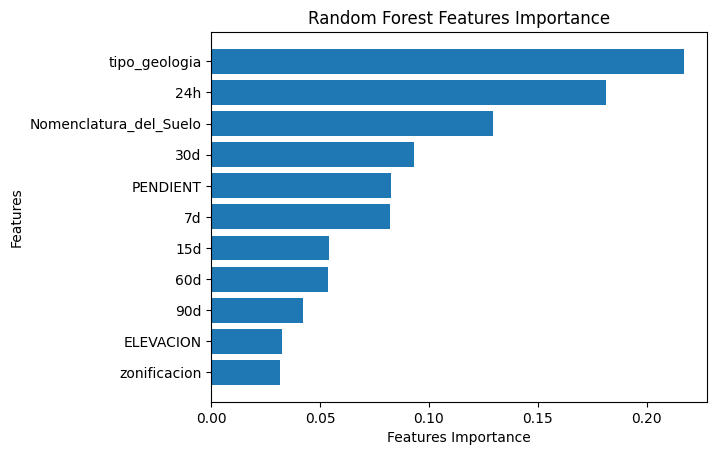

In [240]:
# Importancia de las características para RandomForest
importances = model_rf['classifier'].feature_importances_
features = X_train.columns

# Obtener índices de las importancias ordenadas de mayor a menor
indices = np.argsort(importances)
# Ordenar importancias y características según el índice
sorted_importances = importances[indices]
sorted_features = features[indices]
# Si quieres mostrarlo de manera visual
import matplotlib.pyplot as plt
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Features Importance')
plt.ylabel('Features')
plt.title('Random Forest Features Importance')
plt.show()

En la gráfica vemos que las variables que más tienen valor para que el modelo pueda estimar si existe deslizamiento de tierra o no son `tipo_geologia`, `24h` y `Nomenclatura_del_Suelo`

Exportamos el modelo:

In [231]:
# En esta celda exportamos el modelo para usarlo posteriormente

model_object={'modelo':model_rf
              ,'encoder':label_encoders}
nombre_modelo='random-forest-model'
ruta_m=os.path.join('..','Models','output',f'{nombre_modelo}.pkl')

export_pickle(model_object,ruta_m)

Objeto exportado exitosamente a ../Models/output/random-forest-model.pkl
